<h1 style="text-align: center;">Project title: Customer Churn Prediction for Telecom Operator Interconnect </h1>   

#### Introduction.

In this project, we aim to **predict customer churn** for the telecom operator *Interconnect* using machine learning. The company wants to forecast which users are planning to leave and will offer them promotional codes and special plan options. We start by preprocessing and integrating four datasets, preparing them for exploratory data analysis (EDA). Through feature engineering, we define the key input features and the target variable for a supervised binary classification task.  

To build the churn prediction model, we will train and evaluate several classification algorithms:  

- Logistic Regression  
- Random Forest Classifier  
- LightGBM  
- XGBoost  
- CatBoost
   
Model performance will be evaluated using key metrics, including accuracy, ROC-AUC, and F1 score. Through hyperparameter tuning, our goal is to achieve a ROC-AUC score above 0.75. The best-performing classifier will be selected to reliably predict customer churn for Interconnect.

Finally, the selected model will be used to build and deploy a web application, incorporating core principles of machine learning system design.

## 1. Data sources and preprocessing

In [43]:
# importing packages

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier 

In [45]:
# dowloading datasets
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

### 1.1. Preprocessing of 'contract' dataset

In [48]:
# Preprocessing of 'contract' dataset
print(contract.duplicated().sum())
contract.rename(columns = {'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}, inplace=True)
contract.info()
contract.head()


0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [50]:
# We find out that 'total_charges' column has 11 'whitespace' values. 

empty_values = (contract['total_charges'] == '').sum() + (contract['total_charges'].str.isspace().sum()) 
print(f'empty_values: {empty_values}')
# The empty 'whitespace' values correspond to the customers who just made first month (2020-02-01) payment. 
empty_space_rows = contract[contract['total_charges'].str.isspace()]
print(f'\n {empty_space_rows}')

'''Because these customers made the first (current) month payment, their total payment is equal to their first month payment. 
Thus, we fill ' ' values of the 'total_charges' with the corresponding values of the 'monthly_charges':'''
contract.loc[contract['total_charges'].str.strip() == '', 'total_charges'] = contract['monthly_charges']

# 'monthly_charges' column values are 'float' datatype, while 'total_carges' column values are 'object'. We convert the latter into float datatype: 
# Now, we convert 'total_charges' values into float datatype:
contract['total_charges']= contract['total_charges'].astype(float)

contract.info()  # 'both monthly_charges' and 'total_charges' columns are now have float datatype


empty_values: 11

      customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mai

#### Below we create target column called 'churn'

In [53]:
# Here, according to the project instructions, using the 'end_date' column we create a new target column called 'churn' with '0' 
#corresponding to 'No' values, and '1' corresponding to all other values of 'end_date' column

contract['churn'] = np.where(contract['end_date'] == 'No', 0, 1)   # 0 - no_churned, 1 - churned

contract.info()
contract.head()
print(contract['churn'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   churn              7043 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB
churn
0    5174
1    1869
Name: count, dtype: int64


In [55]:
# here we convert 'begin_date' and 'end_date' columns from 'object' datatype to datetime datatype

contract['begin_date'] = pd.to_datetime(contract['begin_date'])

# for 'end_date' convertion, we use errors = 'coerce' in order to keep 'No' values as a 'NaT' values of the column
contract['end_date'] = pd.to_datetime(contract['end_date'], errors = 'coerce')

#  Here, we find the cutoff date
cutoff_date = contract['end_date'].max()

# now we compute tenure
contract['tenure_days'] = (contract['end_date'].fillna(cutoff_date) - contract['begin_date']).dt.days

# now we can drop both 'begin_date' and 'end_date' columns. they have already been used to create 'churn' and 'tenure_days' columns. 

contract = contract.drop(columns=['begin_date', 'end_date'])

print(contract.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   churn              7043 non-null   int64  
 7   tenure_days        7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB
None


/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_46586/4058662812.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['end_date'] = pd.to_datetime(contract['end_date'], errors = 'coerce')


### 1.2. Preprocessing of 'internet' dataset

In [58]:
internet.info()
print(internet.isna().sum())
print(internet.duplicated().sum())
#No missing values, no duplicates
# Here, we rename columns' names:
internet.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}, inplace=True)
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
0


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [60]:
internet['internet_service'].value_counts() 

internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

### 1.3. Preprocessing of 'personal' dataset

In [63]:
print(personal.info())
print(personal.isna().sum())
print(personal.duplicated().sum())
# No missing values, no duplicates

# Here, we rename the columns' name:
personal.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen', 'Partner':'partner', 'Dependents': 'dependents'}, inplace=True)

print(personal.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
0
     customer_id  gender  senior_citizen partner dependents
4471  2479-BRAMR    Male               1     Yes         No
4192  7137-NAXML    Male               0      No         No
2615  9297-EONCV  Female               0      No         No
3075  5569-IDSEY    Male               0     Yes         No
3724  5201-CBWYG    Male               0     Yes        Yes


### 1.4. Preprocessing of 'phone' dataset

In [66]:
print(phone.info())
print(phone.isna().sum())
print(phone.duplicated().sum())
#No missing values, no duplicates
#Here, we rename the columns' name:
phone.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'}, inplace=True)
print(phone.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
customerID       0
MultipleLines    0
dtype: int64
0
  customer_id multiple_lines
0  5575-GNVDE             No
1  3668-QPYBK             No
2  9237-HQITU             No
3  9305-CDSKC            Yes
4  1452-KIOVK            Yes


## 2. Merging datasets and EDA  

### 2.1. Merging datasets

In [70]:
# All four datasets have 'customer_id' columns. Our master dataset is 'contract' and we merge 'how=left': 
df = contract.merge(personal, on='customer_id', how='left')
df = df.merge(internet, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')

df.isna().sum()


customer_id             0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn                   0
tenure_days             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [72]:
# missing values appeard after left merging the datasets. we fill the missing values 

categorical_cols = [
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'multiple_lines'
]

# Fill NaN with 'No'
df[categorical_cols] = df[categorical_cols].fillna('No')
df.isna().sum()

customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
tenure_days          0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

### 2.2. EDA of merged dataset

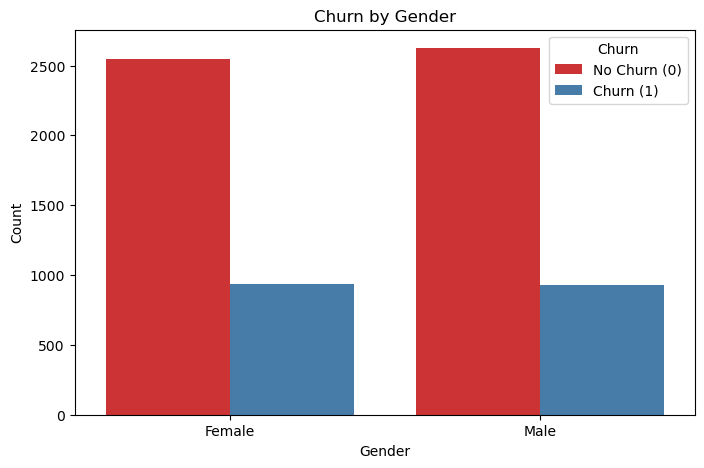

In [75]:
# Create a count plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender', hue='churn', palette='Set1')

# Adding titles and labels
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right', labels=['No Churn (0)', 'Churn (1)'])

plt.show()

In [77]:
# above shown plot demonstrate that 'churn' behaves as independendt from 'male' and 'female' values.
#Therefore we remove 'gender' column from the dataset.
# Also, now we can remove 'customer_id' column beacuse it does not have a value for churn prediction. 

df = df.drop(columns={'customer_id', 'gender'})
df.info() 
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churn              7043 non-null   int64  
 6   tenure_days        7043 non-null   int64  
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,tenure_days,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5466,One year,Yes,Bank transfer (automatic),19.95,219.5,0,275,0,No,Yes,No,No,No,No,No,No,No,No
3082,One year,No,Credit card (automatic),59.90,3043.6,0,1522,0,No,No,DSL,Yes,No,No,Yes,No,No,Yes
6513,Month-to-month,Yes,Bank transfer (automatic),59.65,867.1,0,426,0,Yes,Yes,DSL,No,No,Yes,Yes,No,No,Yes
5000,Month-to-month,Yes,Credit card (automatic),49.50,312.7,0,153,0,No,No,DSL,No,No,No,Yes,No,No,No
6697,One year,Yes,Credit card (automatic),79.30,2427.1,0,883,0,No,No,DSL,Yes,No,Yes,No,Yes,Yes,Yes


## 3. ML training

In [40]:
# defining X(features) and y(target)
X = df.drop('churn', axis=1)
y = df['churn']

#split into temporary and test datasets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

#split into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=12345)

In [64]:
# Here we apply OHE to encode the categorical features and StandardScaler to standardize the numeric features:

categorical_features = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'internet_service', 'online_security', 
                        'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

numerical_features = ['monthly_charges', 'total_charges', 'tenure_days', 'senior_citizen']

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numerical_transformer = StandardScaler()

passthrough_transformer = FunctionTransformer(lambda x: x)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),
        ('passtrough', passthrough_transformer, ['senior_citizen'])   # Here, this code is added in order 'senior_citizen' feature not affected by StandardScaler
    ])


#### Below, we create train_and_evaluate function

In [67]:
def train_and_evaluate_model(pipeline, param_grid, X_train, y_train, X_val, y_val):
    """
    Fits the model using GridSearchCV (including cv=5), makes predictions, and evaluates metrics.
    
    Parameters:
    - pipeline: The model pipeline to train and evaluate.
    - param_grid: The parameter grid for hyperparameter tuning.
    - X_train: Training features.
    - y_train: Training target.
    - X_val: Validation features.
    - y_val: Validation target.
    
    Returns:
    - A dictionary containing best parameters, accuracy, F1 score, and ROC AUC score.
    """
    
    # Grid search
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring=['roc_auc', 'accuracy', 'f1'],
                               refit='roc_auc',
                               cv=5,
                               return_train_score=True)
    
    # Fitting the model
    grid_search.fit(X_train, y_train)
    
    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Makeing predictions on the validation set
    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Calculating the metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    f1 = f1_score(y_val, y_val_pred)
    
    # Printing the results
    print(f'Best Params: {best_params}')
    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Validation ROC AUC: {roc_auc:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1_score': f1,
    }



### 3. 1. Logistic Regression

In [70]:
# Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', random_state=12345))
])

param_grid_logreg = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__max_iter': [100, 200, 300],
}

results_lr = train_and_evaluate_model(pipeline_lr, param_grid_logreg, X_train, y_train, X_valid, y_valid)


Best Params: {'model__C': 1, 'model__max_iter': 100, 'model__solver': 'lbfgs'}
Validation Accuracy: 0.7360
Validation ROC AUC: 0.8204
Validation F1 Score: 0.5903


### 3. 2. RandomForestClassifier model

In [73]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state = 12345))
])

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
}

results_rf = train_and_evaluate_model(pipeline_rf, param_grid_rf, X_train, y_train, X_valid, y_valid)

Best Params: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Validation Accuracy: 0.7821
Validation ROC AUC: 0.8482
Validation F1 Score: 0.6119


### 3. 3. LightGBMClassifier model

In [76]:
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(class_weight='balanced', verbose=-1))
])

param_grid_lgbm = {
    'model__n_estimators': [20, 50],
    'model__max_depth': [5, 10],
    'model__learning_rate': [0.1, 0.2],
    'model__num_leaves': [15, 31],
}

results_lgbm = train_and_evaluate_model(pipeline_lgbm, param_grid_lgbm, X_train, y_train, X_valid, y_valid)

Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__num_leaves': 15}
Validation Accuracy: 0.8034
Validation ROC AUC: 0.8797
Validation F1 Score: 0.6593


### 3. 4. XGBoost model

In [79]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', verbosity=0))
])

param_grid_xgb = {
    'model__n_estimators': [20, 50],
    'model__max_depth': [3, 5, 10],
    'model__learning_rate': [0.1, 0.02],
    'model__subsample': [0.5, 0.8],
    'model__colsample_bytree': [0.5, 0.8],
}

results_xgb = train_and_evaluate_model(pipeline_xgb, param_grid_xgb, X_train, y_train, X_valid, y_valid)

Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 50, 'model__subsample': 0.8}
Validation Accuracy: 0.8474
Validation ROC AUC: 0.8724
Validation F1 Score: 0.6646


### 3. 5. CatBoost model

In [82]:

X = df.drop('churn', axis=1)
y = df['churn']

#split into temporary and test datasets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

#split into train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=12345)

categorical_features = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'internet_service', 'online_security', 
                        'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

# Defining model & param grid

catboost_model = CatBoostClassifier(verbose=0, random_state=42)

param_grid_catboost = {
    'iterations': [50, 100],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}

# GridSearchCV

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid_catboost,
    scoring=['roc_auc', 'accuracy', 'f1'],
    refit='roc_auc',   # the metric used to select the best model
    cv=5,
    return_train_score=True
)

# Pass cat_features explicitly
grid_search.fit(X_train, y_train, cat_features=categorical_features)

# Best model & evaluation

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Params:", best_params)

# Predictions on validation set
y_valid_pred = best_model.predict(X_valid)
y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Metrics
accuracy = accuracy_score(y_valid, y_valid_pred)
roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)
f1 = f1_score(y_valid, y_valid_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation ROC AUC: {roc_auc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

Best Params: {'depth': 7, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Validation Accuracy: 0.8417
Validation ROC AUC: 0.8663
Validation F1 Score: 0.6443


#### Among the above trained and tested models, XGBoost outputs highest ROC-AUC value. Below we use this model with 'test' dataset to make predictions.

Test Accuracy: 0.8488
Test ROC AUC: 0.8829
Test F1 Score: 0.6816


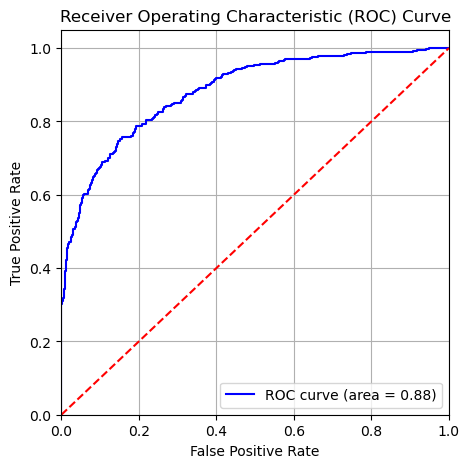

In [85]:
# 'test' dataset with the best XGBoost model:

# Extracting the best model from results
best_xgb_model = results_xgb['best_model']

# Making predictions on the test set
y_test_pred = best_xgb_model.predict(X_test)
y_test_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculating metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# Printing the test metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Conclusion
In this project, we analyzed customer data from the telecom operator Interconnect to build a predictive model for customer churn. The data underwent preprocessing, feature engineering, and exploratory data analysis (EDA) to prepare it for a supervised binary classification task.

For preprocessing, one-hot encoding (OHE) was applied to categorical features and StandardScaler was used for numerical features. Model selection involved cross-validation and hyperparameter tuning with GridSearchCV to ensure robust performance.

We trained and evaluated several classification models, including:

- Logistic Regression  
- Random Forest Classifier  
- LightGBM  
- XGBoost  
- CatBoost

Model performances were evaluated using the accuracy, ROC-AUC, and F1 score metrics. The results are summarized in the table below:


<div style="text-align:center">

| Model                   | Dataset      | Accuracy | ROC-AUC  | F1 Score |
|-------------------------|--------------|----------|----------|----------|
| LogisticRegression      |  validation  |  0.7360  |  0.8204  |  0.5903  |
| RandomForestClassifier  |  validation  |  0.7821  |  0.8482  |  0.6119  |
| LightGBMClassifier      |  validation  |  0.8034  |  0.8797  |  0.6593  |
| XGBClassifier           |  validation  |  0.8474  |  0.8724  |  0.6646  |
| CatboostClassifier      |  validation  |  0.8417  |  0.8663  |  0.6443  |
| XGBClassifier           |     test     |  0.8488  |  0.8829  |  0.6816  |

</div>

After fine-tuning the models' hyperparameters and evaluating them on the test dataset, XGBoost emerged as the best model, achieving a ROC-AUC of 0.8829.

Based on these results, we recommend using the XGBoost model with the tuned hyperparameters to predict customer churn for the company.